In [1]:
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, '2025-01-01')

/var/folders/4d/z8nnzwp97d70g7_c41_g7tkw0000gp/T/ipykernel_14101/2545127703.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-01-02,242.987427,248.218856,240.964609,248.049444,55740700
2025-01-03,242.499146,243.316237,241.034344,242.499146,40244100
2025-01-06,244.133347,246.455106,242.339711,243.445785,45045600
2025-01-07,241.353226,244.681407,240.496267,242.120491,40856000
2025-01-08,241.841476,242.847913,239.200857,241.064237,37628900
...,...,...,...,...,...
2025-09-15,236.699997,238.190002,235.029999,237.000000,42699500
2025-09-16,238.149994,241.220001,236.320007,237.179993,63421100


<Axes: xlabel='Date'>

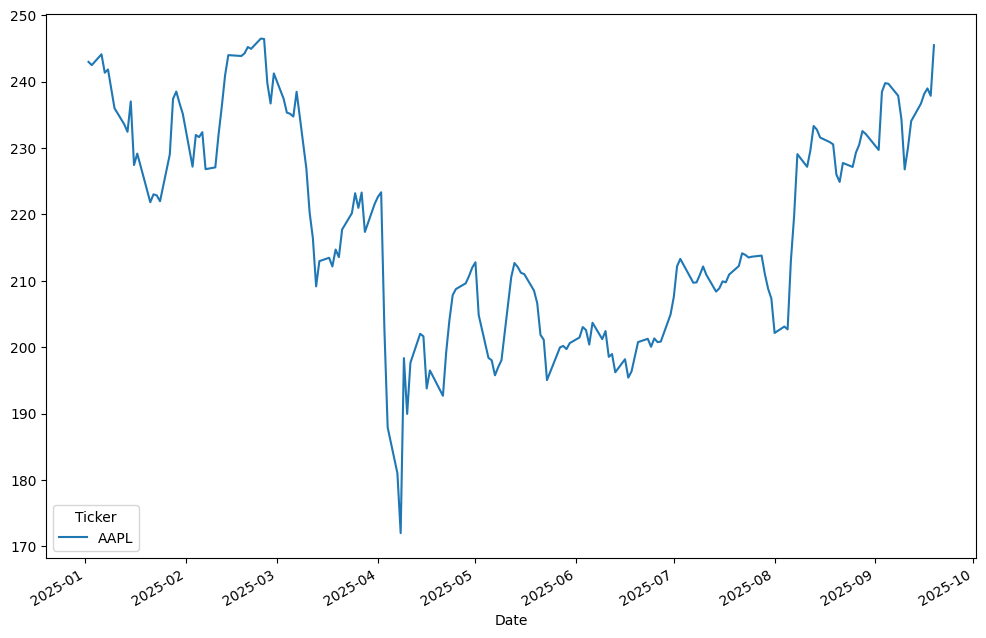

In [5]:
df.Close.plot(figsize=(12,8))

In [6]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [7]:
df.Close

Ticker,AAPL
Date,
2025-01-02,1.551031
2025-01-03,1.520693
2025-01-06,1.622230
2025-01-07,1.449495
2025-01-08,1.479831
...,...
2025-09-15,1.160379
2025-09-16,1.250471
2025-09-17,1.302663


In [8]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [9]:
data

array([[[ 1.55103126],
        [ 1.52069326],
        [ 1.62222979],
        ...,
        [ 1.1350054 ],
        [ 1.42383448],
        [ 1.61411533]],

       [[ 1.52069326],
        [ 1.62222979],
        [ 1.44949473],
        ...,
        [ 1.42383448],
        [ 1.61411533],
        [ 1.60605774]],

       [[ 1.62222979],
        [ 1.44949473],
        [ 1.47983083],
        ...,
        [ 1.61411533],
        [ 1.60605774],
        [ 1.63084957]],

       ...,

       [[-0.95273968],
        [-0.31164098],
        [ 0.10913751],
        ...,
        [ 0.99697227],
        [ 1.16037934],
        [ 1.25047086]],

       [[-0.31164098],
        [ 0.10913751],
        [ 0.68755412],
        ...,
        [ 1.16037934],
        [ 1.25047086],
        [ 1.30266264]],

       [[ 0.10913751],
        [ 0.68755412],
        [ 0.56888042],
        ...,
        [ 1.25047086],
        [ 1.30266264],
        [ 1.23369584]]])

In [10]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [11]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [12]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 ==0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.8960335850715637
25 0.11733826994895935
50 0.06540973484516144
75 0.04323001205921173
100 0.034699585288763046
125 0.017101095989346504
150 0.013116133399307728
175 0.01089942641556263


In [15]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [16]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [17]:
train_rmse

1.5587913990020752

In [18]:
test_rmse

8.513919830322266

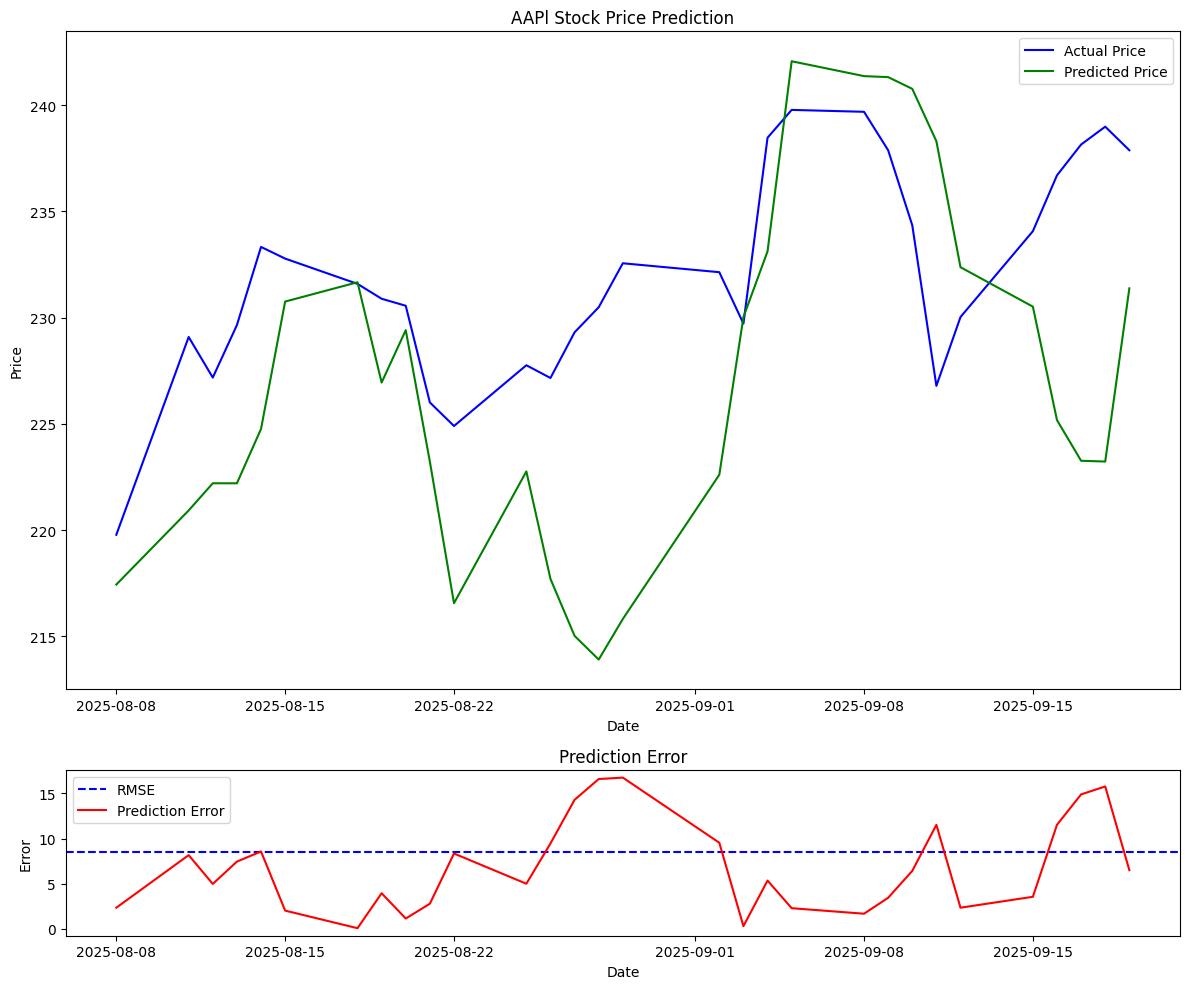

In [19]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

axl = fig.add_subplot(gs[:3, 0])
axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
axl.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()